In [1]:
import os
import json
import sys
import pandas as pd
import torch

PROJECT_ROOT = "/media/ttoxopeus/basic_UNet"

if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)
    print(f"✅ Added project root to sys.path:\n   {PROJECT_ROOT}")
else:
    print(f"ℹ️ Project root already in sys.path:\n   {PROJECT_ROOT}")


from src.training.eval import evaluate
from src.models.unet import UNet
from src.pruning.model_inspect import model_to_dataframe_with_l1, get_pruning_masks_blockwise, compute_actual_prune_ratios, compute_l1_norms, compute_l1_stats
from src.pruning.rebuild import rebuild_pruned_unet, find_prev_conv_name

✅ Added project root to sys.path:
   /media/ttoxopeus/basic_UNet


/media/ttoxopeus/miniconda3/envs/nnunet/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# # Create baseline model
# model = UNet(in_ch=1, out_ch=4, enc_features=[64, 128, 256, 512])
# df = model_to_dataframe_with_l1(model, remove_nan_layers=True)
# pd.set_option('display.max_rows', None)
# display(df)

# 1️⃣ Create model
model = UNet(in_ch=1, out_ch=4, enc_features=[64, 128, 256, 512, 512])
state = torch.load("/media/ttoxopeus/basic_UNet/results/UNet_ACDC/exp41/baseline/training/final_model.pth", map_location="cpu")
model.load_state_dict(state)
model.eval()

# Path to your metrics file
metrics_path = "/media/ttoxopeus/basic_UNet/results/UNet_ACDC/exp41/baseline/evaluation/eval_metrics.json"

# Load JSON
with open(metrics_path, "r") as f:
    metrics = json.load(f)

# Extract values
mean_dice_fg = metrics["mean_dice_fg"]
mean_iou_fg = metrics["mean_iou_fg"]
per_class = metrics["per_class"]

# Print formatted output
print("✅ Evaluation on baseline model!")
print(f"📊 Mean Dice: {mean_dice_fg:.4f}")
print(f"📊 Mean IoU:  {mean_iou_fg:.4f}")
print("───────────────────────────────")

for class_name, vals in per_class.items():
    print(f"{class_name:12s}  Dice={vals['dice_mean']:.4f}  IoU={vals['iou_mean']:.4f}")

print("───────────────────────────────")

✅ Evaluation on baseline model!
📊 Mean Dice: 0.8163
📊 Mean IoU:  0.7528
───────────────────────────────
Background    Dice=0.9974  IoU=0.9949
RV            Dice=0.7623  IoU=0.7062
Myocardium    Dice=0.8062  IoU=0.7186
LV            Dice=0.8805  IoU=0.8337
───────────────────────────────


In [3]:
# 2️⃣ Compute per-filter L1 norms
norms = compute_l1_norms(model)

# 3️⃣ Compute L1 statistics from norms
l1_stats = compute_l1_stats(norms)

# 4️⃣ (Optional) define block ratios for later reference
#block_ratios = {"encoders.0": 0.2, "encoders.1": 0.3, "bottleneck": 0.4}

# 5️⃣ Build DataFrame with stats
df = model_to_dataframe_with_l1(
    model,
    l1_stats=l1_stats,
)

# 6️⃣ Display full DataFrame
pd.set_option("display.max_rows", None)
display(df)


,Layer,Type,Shape,In Ch,Out Ch,Num Params,Mean L1,Min L1,Max L1,L1 Std,Block Ratio,Post-Prune Ratio
0,encoders.0.net.0,Conv2d,"(64, 1, 3, 3)",1,64,576,1.551331,0.941511,2.025421,0.252934,None,None
1,encoders.0.net.1,BatchNorm2d,"(64,)",64,64,128,NaN,NaN,NaN,NaN,None,None
2,encoders.0.net.3,Conv2d,"(64, 64, 3, 3)",64,64,36864,20.288008,14.836420,26.348740,2.820510,None,None
3,encoders.0.net.4,BatchNorm2d,"(64,)",64,64,128,NaN,NaN,NaN,NaN,None,None
4,encoders.1.net.0,Conv2d,"(128, 64, 3, 3)",64,128,73728,20.560497,13.653543,29.073994,4.398217,None,None
5,encoders.1.net.1,BatchNorm2d,"(128,)",128,128,256,NaN,NaN,NaN,NaN,None,None
6,encoders.1.net.3,Conv2d,"(128, 128, 3, 3)",128,128,147456,32.678024,21.367718,49.799278,6.812839,None,None
7,encoders.1.net.4,BatchNorm2d,"(128,)",128,128,256,NaN,NaN,NaN,NaN,None,None
8,encoders.2.net.0,Conv2d,"(256, 128, 3, 3)",128,256,294912,34.095963,20.778049,52.540321,6.267731,None,None
9,encoders.2.net.1,BatchNorm2d,"(256,)",256,256,512,NaN,NaN,NaN,NaN,None,None


In [4]:
block_ratios = {
    # --- Encoder DoubleConvs ---
    "encoders.0": 0.0,
    "encoders.1": 0.0,
    "encoders.2": 0.0,
    "encoders.3": 0.0,
    "encoders.4": 0.0,

    # --- Bottleneck ---
    "bottleneck": 0.0,

    # --- Decoder DoubleConvs only (skip ConvTranspose2d ones) ---
    "decoders.1": 0.0,
    "decoders.3": 0.0,
    "decoders.5": 0.0,
    "decoders.7": 0.0,
    "decoders.9": 0.0,
}


# Then get the pruning masks
masks = get_pruning_masks_blockwise(
    model=model,
    norms=norms,
    block_ratios=block_ratios,
    default_ratio=0.25
)

🔧 Generating pruning masks...

Block encoders.0      | ratio=0.00 → keeping all 64 filters.
Block encoders.0      | ratio=0.00 → keeping all 64 filters.
Block encoders.1      | ratio=0.00 → keeping all 128 filters.
Block encoders.1      | ratio=0.00 → keeping all 128 filters.
Block encoders.2      | ratio=0.00 → keeping all 256 filters.
Block encoders.2      | ratio=0.00 → keeping all 256 filters.
Block encoders.3      | ratio=0.00 → keeping all 512 filters.
Block encoders.3      | ratio=0.00 → keeping all 512 filters.
Block encoders.4      | ratio=0.00 → keeping all 512 filters.
Block encoders.4      | ratio=0.00 → keeping all 512 filters.
Block bottleneck      | ratio=0.00 → keeping all 1024 filters.
Block bottleneck      | ratio=0.00 → keeping all 1024 filters.
Block decoders.1      | ratio=0.00 → keeping all 512 filters.
Block decoders.1      | ratio=0.00 → keeping all 512 filters.
Block decoders.3      | ratio=0.00 → keeping all 512 filters.
Block decoders.3      | ratio=0.00 → ke

🔧 Rebuilding pruned UNet architecture...
✅ Built pruned UNet | enc: [64, 128, 256, 512, 512], dec: [512, 512, 256, 128, 64], bottleneck: 1024
Copied weights for encoders.0.net.0 | shape: torch.Size([64, 1, 3, 3])
Copied weights for encoders.0.net.3 | shape: torch.Size([64, 64, 3, 3])
Copied weights for encoders.1.net.0 | shape: torch.Size([128, 64, 3, 3])
Copied weights for encoders.1.net.3 | shape: torch.Size([128, 128, 3, 3])
Copied weights for encoders.2.net.0 | shape: torch.Size([256, 128, 3, 3])
Copied weights for encoders.2.net.3 | shape: torch.Size([256, 256, 3, 3])
Copied weights for encoders.3.net.0 | shape: torch.Size([512, 256, 3, 3])
Copied weights for encoders.3.net.3 | shape: torch.Size([512, 512, 3, 3])
Copied weights for encoders.4.net.0 | shape: torch.Size([512, 512, 3, 3])
Copied weights for encoders.4.net.3 | shape: torch.Size([512, 512, 3, 3])
Copied weights for bottleneck.net.0 | shape: torch.Size([1024, 512, 3, 3])
Copied weights for bottleneck.net.3 | shape: torc

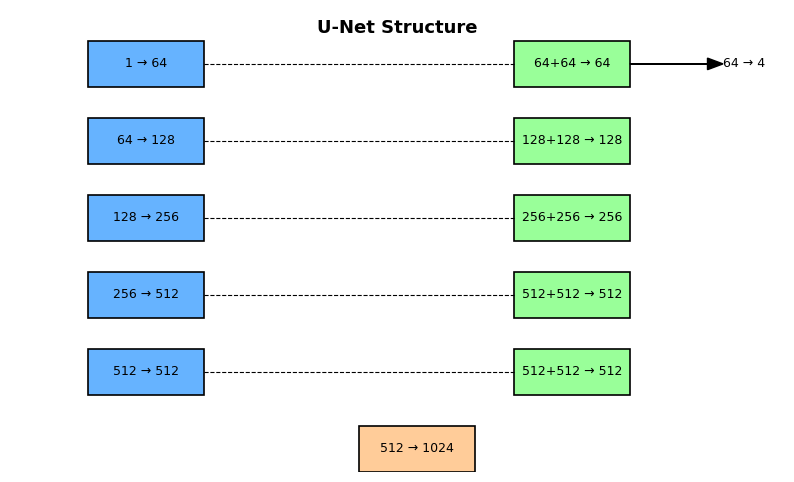

💾 Saved pruned model to /media/ttoxopeus/basic_UNet/results/UNet_ACDC/exp41/pruned/pruned_model.pth
✅ UNet successfully rebuilt.


In [6]:
from pathlib import Path

pruned_model = rebuild_pruned_unet(
    model,
    masks, 
    save_path=Path("/media/ttoxopeus/basic_UNet/results/UNet_ACDC/exp41/pruned/pruned_model.pth"))

post_ratios = compute_actual_prune_ratios(model, pruned_model)

In [7]:
# df_pruned = model_to_dataframe_with_l1(
#     pruned_model,
#     remove_nan_layers=True,
#     block_ratios=block_ratios,
#     post_prune_ratios=post_ratios
# )
# display(df_pruned)


df_pruned = model_to_dataframe_with_l1(
    pruned_model,
    l1_stats=l1_stats,
    remove_nan_layers=False, 
    block_ratios=block_ratios,
    post_prune_ratios=post_ratios
)

display(df_pruned)

,Layer,Type,Shape,In Ch,Out Ch,Num Params,Mean L1,Min L1,Max L1,L1 Std,Block Ratio,Post-Prune Ratio
0,encoders.0.net.0,Conv2d,"(64, 1, 3, 3)",1,64,576,1.551331,0.941511,2.025421,0.252934,0.0,0.0
1,encoders.0.net.1,BatchNorm2d,"(64,)",64,64,128,NaN,NaN,NaN,NaN,0.0,None
2,encoders.0.net.3,Conv2d,"(64, 64, 3, 3)",64,64,36864,20.288008,14.836420,26.348740,2.820510,0.0,0.0
3,encoders.0.net.4,BatchNorm2d,"(64,)",64,64,128,NaN,NaN,NaN,NaN,0.0,None
4,encoders.1.net.0,Conv2d,"(128, 64, 3, 3)",64,128,73728,20.560497,13.653543,29.073994,4.398217,0.0,0.0
5,encoders.1.net.1,BatchNorm2d,"(128,)",128,128,256,NaN,NaN,NaN,NaN,0.0,None
6,encoders.1.net.3,Conv2d,"(128, 128, 3, 3)",128,128,147456,32.678024,21.367718,49.799278,6.812839,0.0,0.0
7,encoders.1.net.4,BatchNorm2d,"(128,)",128,128,256,NaN,NaN,NaN,NaN,0.0,None
8,encoders.2.net.0,Conv2d,"(256, 128, 3, 3)",128,256,294912,34.095963,20.778049,52.540321,6.267731,0.0,0.0
9,encoders.2.net.1,BatchNorm2d,"(256,)",256,256,512,NaN,NaN,NaN,NaN,0.0,None


In [16]:
def interleave_compare(df_base: pd.DataFrame, df_pruned: pd.DataFrame) -> pd.DataFrame:
    """
    Merge two layer-summary dataframes on 'Layer' and interleave
    baseline and pruned columns for easy comparison.

    Returns:
        pd.DataFrame: merged dataframe with interleaved _base and _pruned columns
    """

    # Merge on layer name
    dfm = df_base.merge(df_pruned, on="Layer", how="outer", suffixes=("_base", "_pruned"))

    # Identify columns
    base_cols   = [c for c in dfm.columns if c.endswith("_base")]
    pruned_cols = [c for c in dfm.columns if c.endswith("_pruned")]

    # Build interleaved order
    interleaved = ["Layer"]

    for bc in base_cols:
        stem = bc[:-5]          # remove "_base"
        pc = stem + "_pruned"   # corresponding pruned col
        interleaved.append(bc)
        if pc in dfm.columns:
            interleaved.append(pc)

    # Add any remaining columns
    for c in dfm.columns:
        if c not in interleaved:
            interleaved.append(c)

    return dfm[interleaved]


df_compare = interleave_compare(df, df_pruned)


display(df_compare.iloc[:, 9:])

,Num Params_base,Num Params_pruned,Mean L1_base,Mean L1_pruned,Min L1_base,Min L1_pruned,Max L1_base,Max L1_pruned,L1 Std_base,L1 Std_pruned,Block Ratio_base,Block Ratio_pruned,Post-Prune Ratio_base,Post-Prune Ratio_pruned
0,4718592,4718592,144.267090,144.267090,101.880554,101.880554,178.879700,178.879700,14.665365,14.665365,None,0.0,None,0.0
1,2048,2048,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,0.0,None,None
2,9437184,9437184,223.883591,223.883591,106.554153,106.554153,386.406921,386.406921,57.562244,57.562244,None,0.0,None,0.0
3,2048,2048,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,0.0,None,None
4,2097664,2097664,44.556839,44.556839,25.305153,25.305153,105.051765,105.051765,13.880632,13.880632,None,None,None,None
5,4718592,4718592,238.616776,238.616776,123.579475,123.579475,373.426453,373.426453,47.908344,47.908344,None,0.0,None,0.0
6,1024,1024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,0.0,None,None
7,2359296,2359296,124.202682,124.202682,67.089867,67.089867,196.433594,196.433594,23.418732,23.418732,None,0.0,None,0.0
8,1024,1024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,0.0,None,None
9,1049088,1049088,35.004063,35.004063,25.395571,25.395571,89.083595,89.083595,8.937863,8.937863,None,None,None,None
